# 5. 오차역전파법(역전파)

* 앞 장에서는 신경망 학습을 할 때 가중치 매개변수에 대한 손실 함수의 기울기는 수치 미분을 사용해 구했다.
* 수치 미분은 단순하고 구현하기도 쉽지만, 계산 시간이 오래 걸린다는 단점이 있다.
* 이번 장에서는 가중치 매개변수의 기울기를 효율적으로 계산하는 <span style='color:blue'>오차역전파법(backpropagation)</span>을 배워보자.

## 5.4 단순한 계층 구현하기

* 계산그래프의 곱셈 노드를 'MulLayer' 덧셈 노드를 'AddLayer'라는 이름으로 구현해보자.

### 5.4.1 곱셈 계층

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy
    
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price, '\n', '-'*30)

# 역전파
dprice = 1

dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

220.00000000000003 
 ------------------------------
2.2 110.00000000000001 200


### 5.4.2 덧셈 계층

In [2]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        
        return dx, dy

* 덧셈 계층과 곱셈 계층을 사용하여 사과 2개와 귤 3개를 사는 상황을 구현해보자.

In [3]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price,  dorange_price = add_apple_orange_layer.backward(dall_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(price)
print(dapple,'|',dapple_num,'|',dorange,'|',dorange_num,'|',dtax)

715.0000000000001
2.2 | 110.00000000000001 | 3.3000000000000003 | 165.0 | 650


## 5.5 활성화 함수 계층 구현하기

* ReLU와 Sigmoid 계층을 구현해보자.

### 5.5.1 ReLU 계층

### $y = \begin{cases}x & {(x > 0)} \\ 0 & {(x \le 0)}\end{cases}$<br/>
* 위 식에 대한 미분은 아래와 같다.<br/>
### ${\partial{y}\over\partial{x}} = {\begin{cases}1 & {(x > 0)} \\ 0 & {(x \le 0)}\end{cases}}$<br/>
* 계산그래프로는 아래와 같다.<br/>
<img src="https://velog.velcdn.com/images%2Fkimkihoon0515%2Fpost%2Ff094bb3f-c425-4390-b715-be429399b5a4%2Fimage.png" align="left" height="800px" width="500px">

* 이제 ReLU 계층을 구현해보자.

In [4]:
import numpy as np

class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx
    
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x, '\n', '-'*20)

mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]] 
 --------------------
[[False  True]
 [ True False]]


* ReLU 클래스는 mask라는 인스턴스 변수를 가진다.
* mask는 True/False로 구성된 넘파이 배열로, 순전파의 입력인 x의 원소값이 0 이하인 인덱스는 True로, 그 외는 False로 유지한다.

### 5.5.2 Sigmoid 계층

* 수식으로는 아래와 같다.<br/>
## $y = {1 \over {1 + e^{-x}}}$ <br/>
* 계산 그래프는 아래와 같다.<br/>
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2F8aef041f-e1b3-4077-aa1a-a1e24054ad43%2Fimage.png" align="left" height="500px" width="500px">

* sigmoid 함수의 역전파를 살펴보자.

#### <span style='background-color:yellow'>1단계</span><br/>
* '/' 노드, 즉 $y={1 \over x}$을 미분하면 다음과 같다.<br/>
## ${\partial y \over \partial x} = {-{1 \over x^2}} = {-y^2}$ <br/>
* 위 식에 따르면 역전파 때는 상류에서 하류로 들어온 값에 $-y^2$(순전파의 출력을 제곱한 후 마이너스)을 곱해서 하류로 전달한다. 계산 그래프로는 아래와 같다.<br/>
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2F866b47c6-155f-4a89-a3c3-73373744b5a9%2Fimage.png" align="left" height="500px" width="500px">

#### <span style='background-color:yellow'>2단계</span><br/>
* '+' 노드는 상류의 값을 여과없이 하류로 내보낸다. 계산 그래프에서는 다음과 같다.<br/>
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2F34ef6e35-e205-4015-9de8-087cad876c38%2Fimage.png" align="left" height="500px" width="500px">

#### <span style='background-color:yellow'>3단계</span><br/>
* 'exp' 노드는 $y = e^x$ 연산을 수행하며, 그 미분은 다음과 같다.<br/>
## ${\partial{y}\over\partial{x}} = {e^x}$<br/>
* 계산 그래프에서는 상류의 값에 순전파 때의 출력을 곱해 하류로 전파한다.<br/>
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2F34d261f3-fa57-4fa4-b37c-d3efdf91a41c%2Fimage.png" align="left" height="500px" width="500px">

#### <span style='background-color:yellow'>4단계</span><br/>
* 'x' 노드는 순전파 때의 값을 <span style='color:blue'>서로 바꿔</span> 곱한다.<br/>
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2Fe4fc1d53-2443-477e-a9b0-3e5a9fae8eb3%2Fimage.png" align="left" height="500px" width="500px">

* 이상으로 Sigmoid 계층의 역전파를 계산 그래프로 완성하였다.
* 위 그림에서 보듯이 역전파의 최종 출력인 ${\partial{L}\over\partial{y}}{y^2}{e^{-x}}$ 값이 하류 노트로 전파된다.
* 여기서 위 식은 순전파의 입력 $x$와 출력 $y$ 만으로 계산할 수 있으므로, 계산 그래프의 중간과정을 모두 묶어 단순한 'sigmoid' 노드 하나로 대체할 수 있다.
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2F2b877b61-b267-4852-9022-a9da55c1db00%2Fimage.png" align="left" height="300px" width="300px">

* 또한, ${\partial{L}\over\partial{y}}{y^2}{e^{-x}}$ 는 다음처럼 정리해서 쓸 수 있다.<br/>
## ${\partial{L}\over\partial{y}}{y^2}{e^{-x}}$ = ${\partial{L}\over\partial{y}}{1\over{(1 + e^{-x})^2}}e^{-x}$ = ${\partial{L}\over\partial{y}}{1\over{1 + e^{-x}}}{e^{-x}\over{1 + e^{-x}}}$ = ${\partial{L}\over\partial{y}}{y(1-y)}$<br/>
* 이처럼 Sigmoid 계층의 역전파는 순전파의 출력$(y)$만으로 계산할 수 있다.

In [5]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        
        return dx

## 5.6 Affine/Softmax 계층 구현하기

### 5.6.1 Affine 계층

* 신경망의 순전파에서는 가중치 신호의 총합을 계산하기위해 행렬의 곱을 사용.
* 신경망의 순전파 때 수행하는 행렬의 곱을 기하학에서는 <span style="color:blue">Affine 변환</span>이라고 한다.

In [6]:
import numpy as np

X = np.random.randn(2,)
W = np.random.randn(2, 3)
B = np.random.randn(3)

print(X.shape, W.shape, B.shape, '\n', '-'*30)
Y = np.dot(X, W) + B

print(Y, Y.shape)

(2,) (2, 3) (3,) 
 ------------------------------
[-4.31328586 -1.59568786  4.18814084] (3,)


* 계산 그래프로 그려보면 다음과 같다.<br/>
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2F3e4957c3-2774-40f4-a188-a635cae3c80c%2Fimage.png" align="left" height="300px" width="300px">

* 지금까지의 계산 그래프는 노드 사이에 스칼라값이 흘렀지만, 이 예에서는 <span style='color:blue'>행렬</span>이 흐르고 있다.

* 이제 역전파에 대해 생각해보자.<br/>
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2F15b1ed85-ef9f-4748-bc0d-c68cad4365a8%2Fimage.png" align="left" height="500px" width="500px">

### 5.6.2 배치용 Affine 계층

* 지금까지 설명한 Affine 계층은 입력데이터로 $\mathbf X$ 하나만을 고려한 것이었다.
* 이번 절에서는 데이터 N개를 묶어 순전파 하는 경우, 즉 <span style='color:blue'>배치용 Affine 계층</span>을 생각해 보자.

<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2Fd6d7dc51-82bb-4fac-aa1b-70831aec499c%2Fimage.png" align="left" height="500px" width="600px">

* 기존과 다른 부분은 입력인 $\mathbf X$의 형상이 (N, 2)가 된 것뿐이다.
* 그 뒤로는 지금까지와 같이 계산 그래프의 순서를 따라 행렬 계산을 하게 된다.
* 또, 역전파 때는 행렬의 형상에 주의하면 $\partial{L}\over\partial{X}$과 $\partial{L}\over\partial{W}$은 이전과 같이 도출할 수 있다.
* 편향을 더할 때도 주의해야 한다.
* 순전파 때의 편향 덧셈은 $X\cdot W$에 대한 편향이 각 데이터에 더해진다.
* 예를들어 N = 2인 경우, 편향은 그 두 데이터 각각에 더해진다. 구체적인 예를 보자.

In [7]:
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])

print(X_dot_W, '\n', '-'*20, '\n', X_dot_W + B)

[[ 0  0  0]
 [10 10 10]] 
 -------------------- 
 [[ 1  2  3]
 [11 12 13]]


* 순전파의 편향 덧셈은 각각의 데이터에 더해진다.
* 그래서 역전파 때는 각 데이터의 역전파 값이 편향의 원소에 모여야 한다.

In [8]:
dY = np.array([[1, 2, 3], [4, 5, 6]])
dB = np.sum(dY, axis=0)

print(dY, '\n', '-'*20, '\n', dB)

[[1 2 3]
 [4 5 6]] 
 -------------------- 
 [5 7 9]


In [9]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.dB = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW =  np.dot(self.x.T, dout)
        self.dB = np.sum(dout, axis=0)
        
        return dx

### 5.6.3 Softmax-with-Loss 계층

* 마지막으로 출력층에서 사용하는 softmax 함수에 대해 알아보자.
* softmax 함수는 입력 값을 정규화하여 출력한다.
* softmax 계층을 구현 할 때, 손실함수인 교차 엔트로피 오차도 포함하여 <span style='color:blue'>'softmax_with_loss 계층'</span>으로 구현해보자.
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2Facbf3ae5-e7cf-420e-aaa2-98346d01cd9f%2Fimage.png" align="left" height="500px" width="800px">

* 보다시피 softmax_with_loss 계층은 다소 복잡하다. 위의 계산 그래프를 아래와 같이 간소화 할 수 있다.
<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2F823d0de6-e8e1-40c2-8e51-29a2ebc76b4c%2Fimage.png" align="left" height="500px" width="500px">

* 위의 계산 그래프에서 softmax함수는 'Softmax'계층으로, 교차 엔트로피 오차는 'Cross Entropy Error'계층으로 표기했다.
* Softmax 계층은 입력 $(a_{1}, a_{2}, a_{3})$를 정규화하여 $(y_{1}, y_{2}, y_{3})$를 출력한다.
* Cross Entropy Error 계층은 Softmax의 출력 $(y_{1}, y_{2}, y_{3})$와 정답 레이블 $(t_{1}, t_{2}, t_{3})$를 받고, 이 데이터들로부터 손실 $L$을 출력한다.
* 위 계산 그래프에서 주목할 것은 역전파의 결과이다.
* Softmax 계층의 역전파는 $({y_{1} - t_{1}}, {y_{2} - t_{2}}, {y_{3} - t_{3}})$ 이라는 말끔한 결과를 내놓고 있다.
* 신경망의 역전파에서는 오차(출력과 정답 레이블의 차이)가 앞 계층에 전해진다.

In [10]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

## 5.7 오차역전파법 구현하기

### 5.7.1 신경망 학습의 전체 그림

#### <span style='background-color:yellow'>전제</span> <br/>
신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라고 한다.<br/>신경망 학습은 다음과 같이 4단계로 수행한다.

#### <span style='background-color:yellow'>1단계 - 미니배치</span> <br/>
훈련데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 배치를 <span style='color:blue'>미니배치</span>라 하며, <br/>그 미니배치의 손실 함수 값을 줄이는 것이 목표이다.

#### <span style='background-color:yellow'>2단계 - 기울기 산출</span> <br/>
미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다.<br/>
기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다

#### <span style='background-color:yellow'>3단계 - 매개변수 갱신</span> <br/>
가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

#### <span style='background-color:yellow'>4단계 - 반복</span> <br/>
1~3단계를 반복한다.

* 지금까지 설명한 오차역전파법이 등장하는 단계는 두 번째인 기울기 산출이다.

### 5.7.2 오차역전파법을 적용한 신경망 구현하기

* 신경망을 구현하기 전에, 이 클래스의 인스턴스 변수와 메서드를 정리한 표를 살펴보자.

<img src="https://velog.velcdn.com/images%2Flilpark%2Fpost%2Fe59169aa-7883-446e-890b-16bc518b9b4f%2Fimage.png" align="left" height="700px" width="700px">

In [11]:
def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [12]:
import numpy as np

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads={}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

### 5.7.3 오차역전파법으로 구한 기울기 검증하기

* 수치미분은 오차역전파법에 비해 느리다. 하지만 오차역전파법을 정확히 구현했는지 확인하기 위해 필요하다.
* 수치미분의 이점은 구현하기 쉽다는 것이다. 하지만 오차역전파법은 구현하기 복잡해서 종종 실수를 하곤 한다.
* 그래서 수치미분의 결과와 오차역전파법의 결과를 비교하여 오차역전파법을 제대로 구현했는지 검증하곤 한다.
* 이처럼 두 방식으로 구한 기울기가 일치함을 확인하는 작업을 <span style="color:blue">기울기 확인</span>이라고 한다
* 기울기 확인은 다음과 같이 구현한다.

In [13]:
import numpy as np
from mnist import load_mnist
from collections import OrderedDict

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후, 그 절댓값들의 평균을 낸다
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:5.894402783091998e-10
b1:3.389520343303944e-09
W2:6.170298644618993e-09
b2:1.4022778820621528e-07


* 이 결과는 수치미분과 오차역전파법으로 구한 기울기의 차이가 매우 작다고 말해준다.
* 이로써 오차역전파법으로 구한 기울기도 올바름이 드러나면서 실수없이 구현했다는 믿음이 커진다.

### 5.7.4 오차역전파법을 사용한 학습 구현하기

In [14]:
import numpy as np
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 오차역전파법으로 기울기를 구한다.
    grad = network.gradient(x_batch, t_batch)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.12058333333333333 0.1233
0.9007833333333334 0.9028
0.9218666666666666 0.9245
0.9353 0.9354
0.9443 0.9431
0.95285 0.9498
0.9567333333333333 0.9532
0.9610833333333333 0.9581
0.9647 0.9604
0.9684333333333334 0.9627
0.9692833333333334 0.9654
0.9721166666666666 0.9664
0.9732666666666666 0.9658
0.97585 0.9683
0.9775666666666667 0.9675
0.9790833333333333 0.9706
0.9802666666666666 0.9711


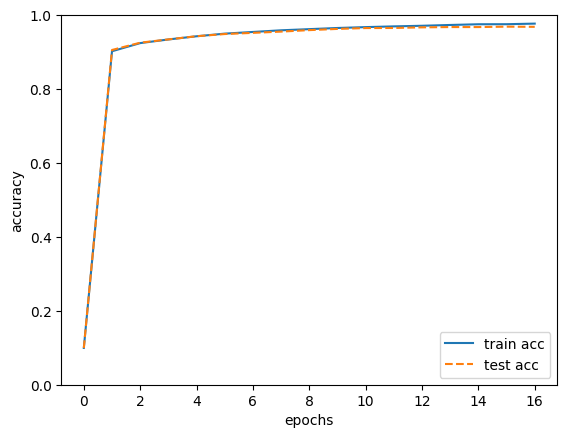

In [17]:
import matplotlib.pyplot as plt

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()